In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, cos, sin, sqrt, exp

# Piecewise Exact Integration

## The Dynamical System

We want to study a damped SDOF system, so characterized

In [2]:
T=1.0                  # Natural period of the oscillator
w=2*pi                 # circular frequency of the oscillator

m=1000.0               # oscillator's mass, in kg
k=m*w*w                # oscillator stifness, in N/m
z=0.05                 # damping ratio over critical
c=2*z*m*w              # damping

wd=w*sqrt(1-z*z)       # damped circular frequency
ratio=sqrt(1-z*z)      # ratio damped/undamped frequencies

The excitation is given by a force such that the static displacement is 5 mm, modulated by a sine _in resonance_ with the dynamic sistem, i.e., $\omega=\omega_n$.

In [3]:
D=0.005                # static displacement, 5mm
P=D*k                  # force amplitude

For such a system, we know exactly the response.  The particular integral is 

$$\xi(t)=-\frac{\cos\omega t}{2\zeta}$$

and imposing rest initial conditions it is

$$x(t) = \frac{\Delta_{st}}{2\zeta} ((\frac{\zeta}{\sqrt{1=\zeta^2}}\sin\omega_Dt + \cos\omega_Dt)\exp(-\zeta\omega t) - \cos\omega t),\qquad \omega=\omega_n.
$$

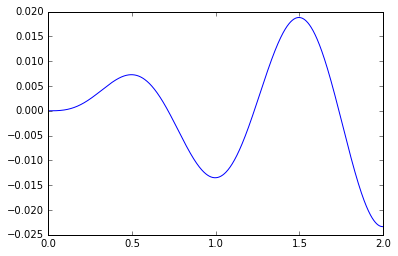

In [4]:
def exact(t):
    return D*((z*sin(wd*t)/ratio+cos(wd*t))*exp(-z*w*t)-cos(w*t))/(2*z)
t = np.linspace(0.0, 2.0, 1001)
plt.plot(t, exact(t));

## Numerical integration

Now we prepare for the numerical integration, first the constants that represent the homogeneous response at end of step

In [5]:
def initstep(h):
    cdh=cos(wd*h)*exp(-z*w*h)
    sdh=sin(wd*h)*exp(-z*w*h)
    return cdh, sdh

then the actual step computations, where in terms of the initial state vector and the load variation the final state is derived.

In [6]:
def step(x0,v0,p0,p1,h,cdh,sdh):
    dst=p0/k
    ddst=(p1-p0)/k
    B = x0 - dst + ((2*z)/w)*(ddst/h)
    A = (v0 + z*w*B - ddst/h)/wd
    x1 = A*sdh + B*cdh + dst + ddst - ddst/h * 2*z/w
    v1 = A*(wd*cdh-z*w*sdh) - B*(z*w*cdh+wd*sdh) + ddst/h
    return x1, v1

With those pieces in place, we can define a function that, for a given number of steps per period computes the response on the interval $0 \le t \le 2.0$.

In [7]:
def resp(nstep):
    T = np.linspace(0.0, 2.0, 2*nstep + 1)
    X = np.zeros(2*nstep + 1)
    
    h=1./float(nstep)
    cdh, sdh = initstep(h)
    x1=0. ; v1=0. ; p1=0
    
    for i, t in enumerate(T):
        X[i] = x1
        x0=x1 ; v0=v1 ; p0=p1 ; p1=P*sin(w*(t+h))
        x1,v1=step(x0,v0,p0,p1,h, cdh, sdh)
    return T, X

Let's compute the responses for different numbers of steps, and store them away too...

In [8]:
t_x = {n:resp(n) for n in (4, 8, 16)}

Eventually we can plot the numerical responses along with the exact response

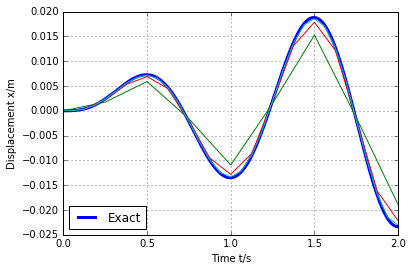

In [9]:
plt.plot(t, exact(t), label='Exact', lw=3)
plt.plot(*t_x[4], *t_x[8], *t_x[16])
plt.grid()
plt.legend(loc=3)
plt.xlabel('Time t/s')
plt.ylabel('Displacement x/m');

But... there are only two numerical curves and I've plotted three of them.

Let's plot the _difference_ between the exact response and the response computed at 16 samples per period...

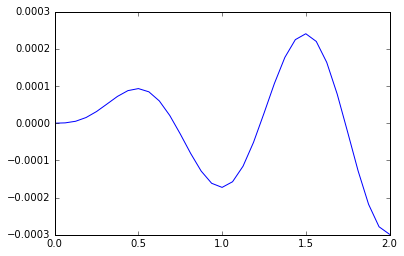

In [10]:
t16, x16 = t_x[16]
plt.plot(t16, exact(t16)-x16)

As you can see, the max difference is about 0.3 mm, to be compared with a max response of almost 25 mm, hence an error in the order of 1.2% that in the previous plot led to the apparent disappearance of the `NSTEP=16` curve.